# Sentiment Based Product Recommendation System
Name: Saurabh Dugdhe

## Problem Statement
Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

1. Data sourcing and sentiment analysis
2. Building a recommendation system
3. Improving the recommendations using the sentiment analysis model
4. Deploying the end-to-end project with a user interface

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

## Understanding the dataset and Exploratory Data Analysis

In [154]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score

from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

import pickle
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
df.shape

(30000, 15)

In [4]:
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# Print % of null values in the dataset
(df.isnull().sum()/len(df))*100

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

The user city and provinces have more than 99% null values. Let us drop these columns.

### Data Cleaning

In [7]:
df_cleaned = df.drop(axis=1, columns=["reviews_userCity", "reviews_userProvince"])

There are 0.3333% of records for user_sentiment where value is null. We cannot impute this data. Let us drop these records as they are very small in number.

In [8]:
df_cleaned = df_cleaned.drop(df[df["user_sentiment"].isnull()].index)

In [9]:
df_cleaned.shape

(29999, 13)

In [10]:
df_cleaned["user_sentiment"].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

Let us map the values of `user_sentiment` to categories <br>
Positive = 1<br>
Negative = 0

In [11]:
df_cleaned["user_sentiment"] = df_cleaned['user_sentiment'].map({'Positive':1,'Negative':0})

Let us remove null values from username

In [12]:
#removing nan/null from username
df_cleaned = df_cleaned[~df_cleaned.reviews_username.isnull()]

There are some missing review_title. Instead of removing these titles, let us merge them with reviews_text so that we can get more data for analysis.

In [13]:
df_cleaned["reviews_title"] = df_cleaned["reviews_title"].fillna(" ")

df_cleaned["reviews_fullreview"] = df_cleaned["reviews_title"].astype(str) + " " + df_cleaned["reviews_text"].astype(str) 

In [14]:
df_cleaned.drop(axis=1, columns=["reviews_title", "reviews_text"], inplace=True)

In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29936 non-null  object
 1   brand                29936 non-null  object
 2   categories           29936 non-null  object
 3   manufacturer         29795 non-null  object
 4   name                 29936 non-null  object
 5   reviews_date         29896 non-null  object
 6   reviews_didPurchase  15931 non-null  object
 7   reviews_doRecommend  27395 non-null  object
 8   reviews_rating       29936 non-null  int64 
 9   reviews_username     29936 non-null  object
 10  user_sentiment       29936 non-null  int64 
 11  reviews_fullreview   29936 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.0+ MB


### Exploratory Data Analysis

#### Rating Trend

Let us see what is the general rating trend in the dataset

In [16]:
rating_cnt = df_cleaned["reviews_rating"].value_counts()

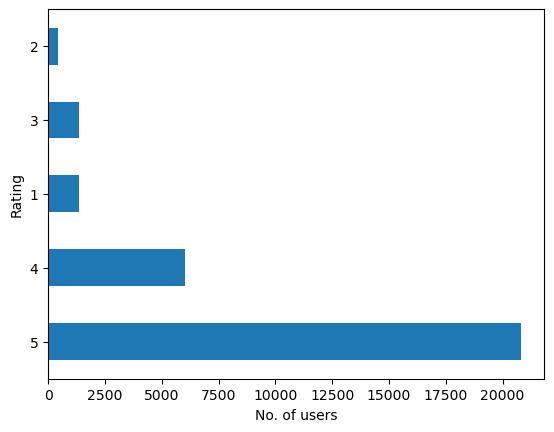

In [17]:
plt.ylabel("Rating")
plt.xlabel("No. of users")
rating_cnt.plot(kind='barh')
plt.show()

#### User Sentiment Distribution

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

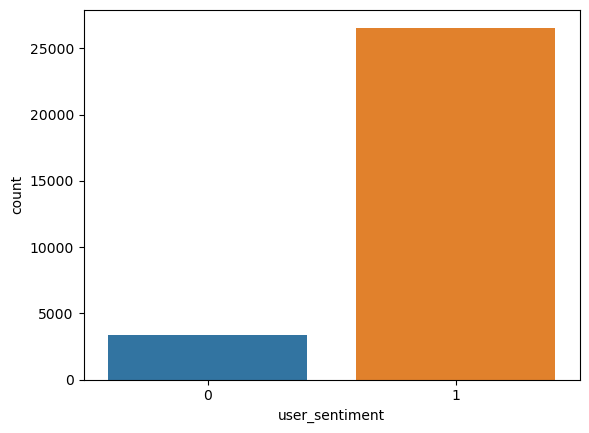

In [18]:
sns.countplot(x="user_sentiment", data= df_cleaned)

There is a class imbalance in user sentiment data. We need to perform oversampling for this data.

#### Exploring relationship between `user_sentiment` and `reviews_rating`

Let us look at the relationship between `reviews_rating` and `user_sentiment`

In [19]:
pd.crosstab(df_cleaned["reviews_rating"], df_cleaned["user_sentiment"])

user_sentiment,0,1
reviews_rating,,
1,593,780
2,140,278
3,219,1125
4,550,5460
5,1855,18936


From above cross tabulation, we can see that there are negative sentiments for highly rated products , while there are positive sentiments for lower ratings. <br>
Let us update the column to rectify the user sentiment.<br>
Let us update sentiments as follows<br>
1. Rating 1 - Negative<br>
2. Rating 2 - Negative<br>
3. Rating 3 - Mixed<br>
4. Rating 4 - Positive<br>
5. Rating 5 - Positive<br>

In [20]:
df_cleaned.loc[(df_cleaned["user_sentiment"]==1) & (df_cleaned["reviews_rating"]<3), "user_sentiment"] = 0

In [21]:
df_cleaned.loc[(df_cleaned["user_sentiment"]==0) & (df_cleaned["reviews_rating"]>3), "user_sentiment"] = 1

In [22]:
pd.crosstab(df_cleaned["reviews_rating"], df_cleaned["user_sentiment"])

user_sentiment,0,1
reviews_rating,,
1,1373,0
2,418,0
3,219,1125
4,0,6010
5,0,20791


#### Top 5 rated brands with positive sentiments

In [23]:
df_cleaned.brand.value_counts()

Clorox                   10565
Warner Home Video         3325
Disney                    1199
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
SLOAN VALVE COMPANY          1
Southern Enterprises         1
Universal Music              1
Name: brand, Length: 214, dtype: int64

In [24]:
positiverated_brands_count = df_cleaned[df_cleaned["user_sentiment"] == 1].groupby("brand")["brand"].count()

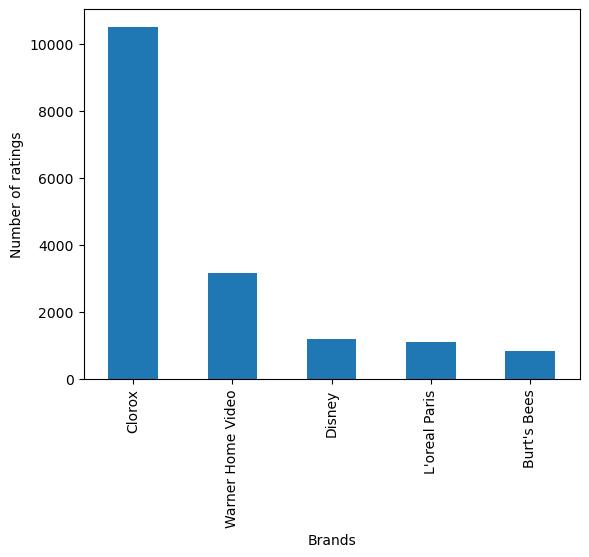

In [25]:
positiverated_brands_count.sort_values(ascending=False)[:5].plot.bar()
plt.ylabel("Number of ratings")
plt.xlabel("Brands")
plt.show()

#### Top 5 brands with negative sentiments

In [26]:
negativerated_brands_count = df_cleaned[df_cleaned["user_sentiment"] == 0].groupby("brand")["brand"].count()

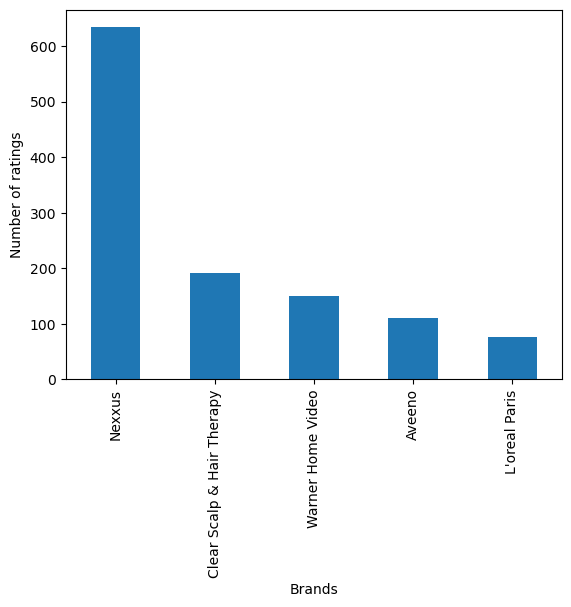

In [27]:
negativerated_brands_count.sort_values(ascending=False)[:5].plot.bar()
plt.ylabel("Number of ratings")
plt.xlabel("Brands")
plt.show()

#### Top 5 users with positive sentiments

In [28]:
positiverated_user_count = df_cleaned[df_cleaned["user_sentiment"] == 1].groupby("reviews_username")["reviews_username"].count()

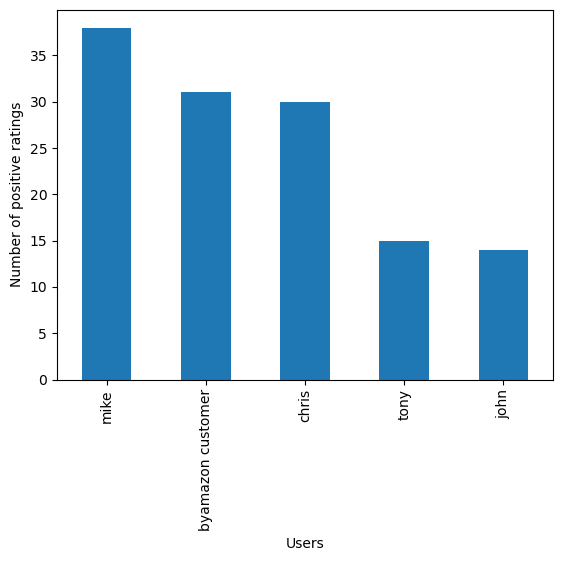

In [29]:
positiverated_user_count.sort_values(ascending=False)[:5].plot.bar()
plt.ylabel("Number of positive ratings")
plt.xlabel("Users")
plt.show()

#### Top 5 users with negative sentiments

In [30]:
negativerated_user_count = df_cleaned[df_cleaned["user_sentiment"] == 0].groupby("reviews_username")["reviews_username"].count()

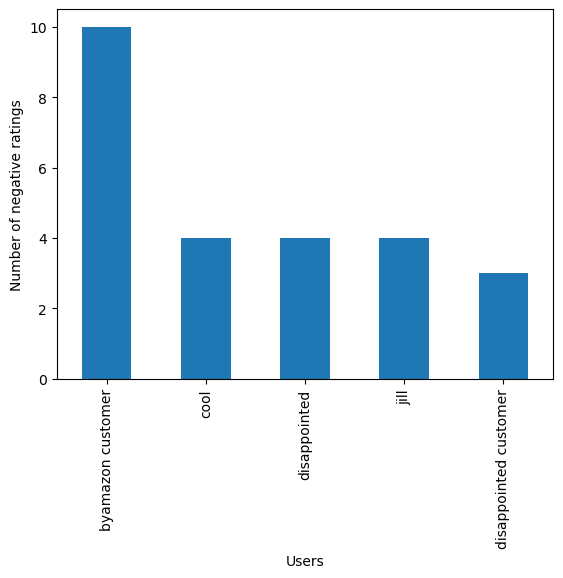

In [31]:
negativerated_user_count.sort_values(ascending=False)[:5].plot.bar()
plt.ylabel("Number of negative ratings")
plt.xlabel("Users")
plt.show()

## Text Preprocessing

### Importing libraries

In [32]:
import string
import re
import nltk
import spacy
import en_core_web_sm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
nlp = en_core_web_sm.load()

In [33]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10053]
[nltk_data]     An established connection was aborted by the software
[nltk_data]     in your host machine>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [34]:
df_cleaned.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,reviews_fullreview
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,joshua,1,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,dorothy w,1,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,dorothy w,1,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,rebecca,0,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,walker557,0,Irritation My husband bought this gel for us. ...


In [35]:
df_cleaned["reviews_fullreview"] = df_cleaned["reviews_fullreview"].astype(str)

### Cleaning the text

Let us clean the text present in the `reviews_fullreview` columns
1. Convert the entire text corpus to lower case.
2. Remove whitespace in the reviews.
3. Remove square brackets
4. Remove punctuation
5. Remove words with numbers

#### Clean text

In [36]:
# function to clean the sentences
def cleanSentence(sentence):
    # convert text to lowercase
    sentence = sentence.lower()
    
    # Remove unnecessary whitespace
    sentence = sentence.strip()
    
    # Remove Text in Square brackets
    sentence = re.sub('\[.*\]', ' ', sentence)
    
    # Remove Punctuation
    sentence = re.sub('[^\w\s]', ' ', sentence)
    
    # Remove words with a number
    sentence = re.sub('\w*\d\w*', ' ', sentence)
    
    return sentence    

In [37]:
# Apply cleanSentence to column 'reviews_fullreview'
df_cleaned["reviews_cleanedtext"] = df_cleaned["reviews_fullreview"].apply(lambda x: cleanSentence(x))

In [38]:
# Print one entry of the cleaned text
df_cleaned["reviews_cleanedtext"][0]

'just awesome i love this album  it s very good  more to the hip hop side than her current pop sound   so hype  i listen to this everyday at the gym  i give it   rating all the way  her metaphors are just crazy '

#### Remove stopwords

In [40]:
# Stop words
stop_words = set(stopwords.words('english'))

#Removing stopwords
def RemoveStopwords(sentence):
    wordsList = [word for word in sentence.split() if (word.isalpha()) and (word not in stop_words)]
    return " ".join(wordsList)
  

In [41]:
# Remove stopwords from column 'reviews_cleanedtext'
df_cleaned["reviews_Lemmatext"] = df_cleaned["reviews_cleanedtext"].apply(lambda x: RemoveStopwords(x))

In [42]:
# Print 1 record
df_cleaned["reviews_Lemmatext"][1]

'good good flavor review collected part promotion'

#### Lemmatize the text

In [39]:
# Lemmatize the texts
def Lemmatization(sentence):
    lemmas = []
    nlpSent = nlp(sentence)
    for token in nlpSent:
        lemmas.append(token.lemma_)
    lemmatizedSentence = " ".join(lemmas)
    return lemmatizedSentence

In [43]:
# Lemmatize the text in 'reviews_Lemmatext'
df_cleaned["reviews_Lemmatext"] = df_cleaned["reviews_Lemmatext"].apply(lambda x: Lemmatization(x))

In [44]:
# Print one record
df_cleaned["reviews_Lemmatext"][1]

'good good flavor review collect part promotion'

### EDA and visualization on pre-processed text

#### Character length

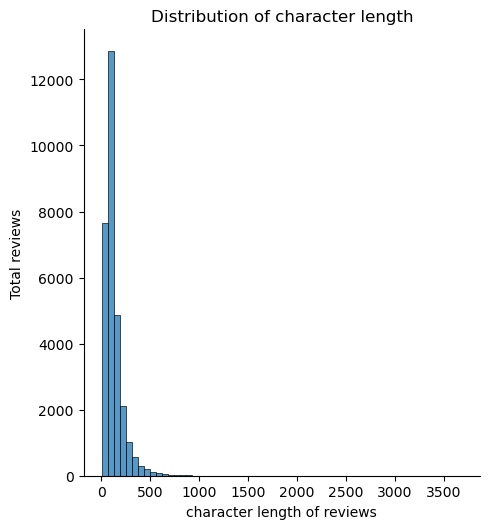

In [45]:
# Write your code here to visualize the data according to the 'review' character length
charlen = [len(sent) for sent in df_cleaned['reviews_Lemmatext']]
sns.displot(charlen, kind='hist', bins=60)
plt.xlabel("character length of reviews")
plt.ylabel("Total reviews")
plt.title("Distribution of character length")
plt.show()

#### Word Cloud

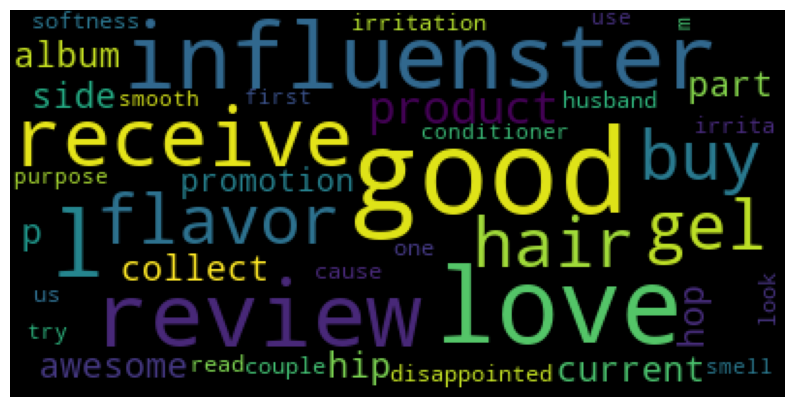

In [46]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wc = WordCloud(max_font_size=60, max_words=40, random_state=100, stopwords=stopwords).generate(str(df_cleaned["reviews_Lemmatext"]))
plt.figure(figsize=[10,10])
plt.imshow(wc)
plt.axis("off")
plt.show()

#### Unigrams, Bigrams and Trigrams

Find unigrams, bigrams, and trigrams by frequency among all the reviews after processing the text.

In [47]:
def getNgrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    words_freq = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

##### Positive Unigrams

In [48]:
#Write your code here to find the top 10 unigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10unigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==1]['reviews_Lemmatext'], n=10, ngram=(1,1))
dfUnigram = pd.DataFrame(top10unigram, columns=['unigram', 'frequency'])
dfUnigram

,unigram,frequency
0,great,14844
1,love,12736
2,use,12359
3,product,11321
4,movie,10623
5,review,9217
6,good,8861
7,collect,8646
8,promotion,8626
9,wipe,8324


##### Negative Unigrams

In [49]:
#Write your code here to find the top 10 unigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10unigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==0]['reviews_Lemmatext'], n=10, ngram=(1,1))
dfUnigram = pd.DataFrame(top10unigram, columns=['unigram', 'frequency'])
dfUnigram

,unigram,frequency
0,product,1509
1,use,1473
2,formula,1427
3,new,1202
4,hair,1136
5,old,1003
6,gel,870
7,like,744
8,change,638
9,smell,624


##### Positive Bigrams

In [50]:
#Write your code here to find the top 10 bigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10bigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==1]['reviews_Lemmatext'], n=10, ngram=(2,2))
dfBigram = pd.DataFrame(top10bigram, columns=['bigram', 'frequency'])
dfBigram

,bigram,frequency
0,review collect,8621
1,collect promotion,8621
2,clorox wipe,2827
3,great product,1998
4,great movie,1775
5,easy use,1610
6,love clorox,1231
7,love product,1179
8,use clorox,1102
9,good movie,1089


##### Negative Bigrams

In [51]:
#Write your code here to find the top 10 bigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10bigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==0]['reviews_Lemmatext'], n=10, ngram=(2,2))
dfBigram = pd.DataFrame(top10bigram, columns=['bigram', 'frequency'])
dfBigram

,bigram,frequency
0,new formula,522
1,old formula,513
2,bring old,358
3,exxtra gel,204
4,use product,169
5,product year,125
6,gel year,122
7,review collect,120
8,collect promotion,120
9,shampoo conditioner,119


##### Positive Trigrams

In [52]:
#Write your code here to find the top 10 trigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10trigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==1]['reviews_Lemmatext'], n=10, ngram=(3,3))
dfTrigram = pd.DataFrame(top10trigram, columns=['trigram', 'frequency'])
dfTrigram

,trigram,frequency
0,review collect promotion,8621
1,love clorox wipe,605
2,clorox disinfecting wipe,565
3,use clorox wipe,555
4,clean review collect,466
5,product review collect,423
6,use review collect,361
7,receive product free,301
8,great product love,295
9,great movie great,273


##### Negative Trigrams

In [53]:
#Write your code here to find the top 10 trigram frequency among the complaints in the cleaned dataframe(df_cleaned). 
top10trigram = getNgrams(df_cleaned[df_cleaned['user_sentiment']==0]['reviews_Lemmatext'], n=10, ngram=(3,3))
dfTrigram = pd.DataFrame(top10trigram, columns=['trigram', 'frequency'])
dfTrigram

,trigram,frequency
0,bring old formula,236
1,review collect promotion,120
2,use product year,86
3,nexxus exxtra gel,62
4,exxtra gel year,43
5,use old formula,43
6,use gel year,40
7,use exxtra gel,37
8,use nexxus exxtra,37
9,old formula use,36


## Feature Extraction

In [54]:
# Initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, max_features=400, stop_words='english')

In [55]:
# Create the Document Term Matrix by transforming the reviews column present in df_cleaned.
dtm = tfidf.fit_transform(df_cleaned['reviews_Lemmatext'])

In [56]:
# print the feature names
print(tfidf.get_feature_names_out())

['able' 'absolutely' 'action' 'actor' 'actually' 'add' 'age' 'ago'
 'amazing' 'apply' 'area' 'away' 'awesome' 'baby' 'bad' 'bag' 'balm'
 'bathroom' 'beautiful' 'bee' 'big' 'bit' 'black' 'bleach' 'blu' 'body'
 'bottle' 'box' 'boy' 'brand' 'break' 'bring' 'brown' 'burt' 'buy'
 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd' 'chair' 'change'
 'character' 'cheap' 'child' 'chili' 'chip' 'classic' 'classroom' 'clay'
 'clean' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox' 'close' 'cocoa'
 'cold' 'collect' 'collection' 'color' 'come' 'comedy' 'compare'
 'complimentary' 'conditioner' 'container' 'continue' 'convenience'
 'convenient' 'cool' 'counter' 'couple' 'cover' 'cream' 'curly' 'customer'
 'cut' 'daily' 'dark' 'daughter' 'day' 'deal' 'decent' 'decide' 'deep'
 'definitely' 'delicious' 'desk' 'difference' 'different' 'disappoint'
 'disappointed' 'disinfect' 'disinfecting' 'disney' 'dog' 'door' 'dry'
 'dvd' 'ease' 'easily' 'easy' 'eat' 'effect' 'effective' 'end' 'enjoy'
 'entertain' 'en

In [57]:
# Identify x and y for train test split
X = dtm
y = df_cleaned["user_sentiment"]

## Model training and evaluation

### Test-Train Split

In [58]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

#### Resolve Class Imbalance using SMOTE oversampling

In [59]:
cnt = Counter(y_train)
print('Original class distribution', cnt)

sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

cnt = Counter(y_train)
print('Class distribution after SMOTE resampling', cnt)

Original class distribution Counter({1: 20935, 0: 1517})
Class distribution after SMOTE resampling Counter({1: 20935, 0: 20935})


As we can see that the class imbalance is resolved by oversampling the data.

### Model Building

#### Helper Methods

In [60]:
# Helper methods

# Evaluate model method evaluates the model on Accuracy, precision, recall, and f1 score
def evaluateModel(y_test, y_pred):
    metrics = [] 
    accuracy = accuracy_score(y_test, y_pred)
    metrics.append(accuracy)

    recall = recall_score(y_test, y_pred)
    metrics.append(recall)

    precision = precision_score(y_test, y_pred)
    metrics.append(precision)
    
    f1score = f1_score(y_test, y_pred)
    metrics.append(f1score)
    
    print(f"Accuracy is : {accuracy*100:.1f}%")
    print(f"Precision is : {precision*100:.1f}%")
    print(f"Recall is : {recall*100:.1f}%")
    print(f"F1 Score is : {f1score*100:.1f}%")    
    
    print(classification_report(y_test, y_pred))
    return metrics

# plot the confusion matrix
def plotConfusionMatrix(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(color_codes=True)
    plt.title("Confusion Matrix")
    ax = sns.heatmap(confusionMatrix/np.sum(confusionMatrix), fmt=".2%", annot=True, cmap="Greens")
    ax.set_xticklabels([0,1])
    ax.set_yticklabels([0,1])
    ax.set(ylabel="Actual Values", xlabel="Predicted Values")
    plt.show()

#### Logistic Regression

In [61]:
# Logistic regression
LR = LogisticRegression(random_state=42, max_iter=100, solver="liblinear", class_weight="balanced")
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

In [62]:
metrics_LR = evaluateModel(y_test, y_pred_LR)

Accuracy is : 91.2%
Precision is : 98.7%
Recall is : 91.8%
F1 Score is : 95.1%
              precision    recall  f1-score   support

           0       0.42      0.83      0.55       493
           1       0.99      0.92      0.95      6991

    accuracy                           0.91      7484
   macro avg       0.70      0.87      0.75      7484
weighted avg       0.95      0.91      0.93      7484



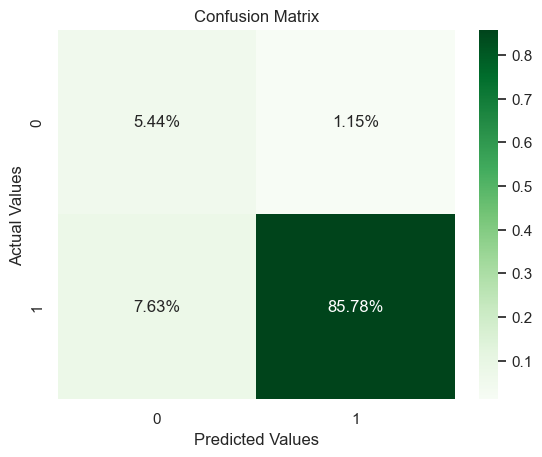

In [63]:
plotConfusionMatrix(y_test, y_pred_LR)

#### Random Forest

In [64]:
RF = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

In [65]:
params_rf = {
    'max_depth': [2, 5, 7, 10, 12, 15, 20],
    'min_samples_leaf': [5, 10, 20, 30, 50],
    'n_estimators': [5, 10, 20, 30, 50, 100]
}

In [66]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RF, param_grid=params_rf, cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [67]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 210 candidates, totalling 840 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 10, 12, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 30, 50],
                         'n_estimators': [5, 10, 20, 30, 50, 100]},
             scoring='f1', verbose=1)

In [68]:
RF_best = grid_search.best_estimator_
RF_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, random_state=42)

In [69]:
y_pred_RF = RF_best.predict(X_test)

In [70]:
metrics_RF = evaluateModel(y_test, y_pred_RF)

Accuracy is : 92.0%
Precision is : 98.3%
Recall is : 93.0%
F1 Score is : 95.6%
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       493
           1       0.98      0.93      0.96      6991

    accuracy                           0.92      7484
   macro avg       0.71      0.85      0.76      7484
weighted avg       0.95      0.92      0.93      7484



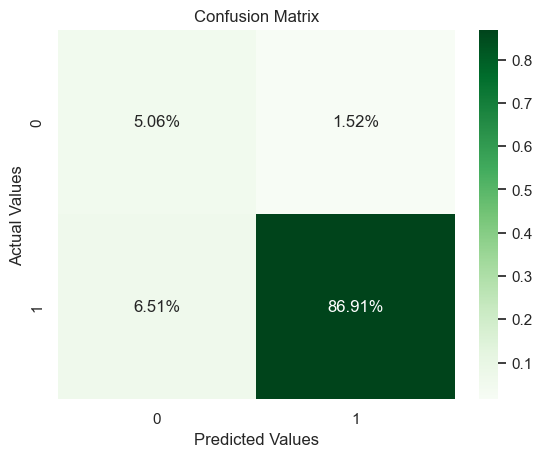

In [71]:
plotConfusionMatrix(y_test, y_pred_RF)

#### Naive Bayes

In [72]:
mNB = MultinomialNB()
mNB.fit(X_train, y_train)
y_pred_mNB = mNB.predict(X_test)

In [73]:
metrics_mNB = evaluateModel(y_test, y_pred_mNB)

Accuracy is : 89.6%
Precision is : 98.3%
Recall is : 90.4%
F1 Score is : 94.2%
              precision    recall  f1-score   support

           0       0.36      0.77      0.49       493
           1       0.98      0.90      0.94      6991

    accuracy                           0.90      7484
   macro avg       0.67      0.84      0.72      7484
weighted avg       0.94      0.90      0.91      7484



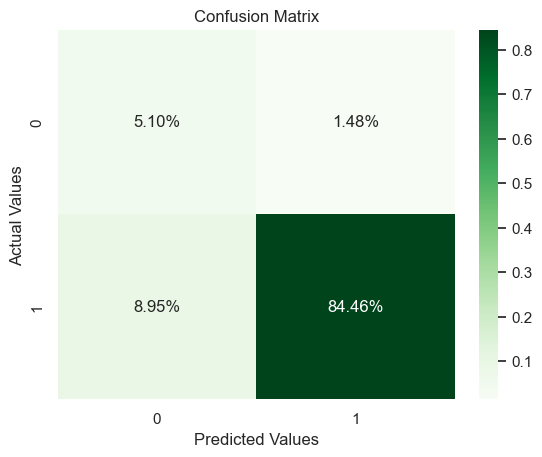

In [74]:
plotConfusionMatrix(y_test, y_pred_mNB)

#### XGBoost

In [79]:
XGB = xgb.XGBClassifier()
params_xgb = {
        'n_estimators' : [10, 50, 80, 100], # no of trees 
        'learning_rate' : [0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5

random_search = RandomizedSearchCV(XGB, param_distributions=params_xgb, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=42)

In [80]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[20:09:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [81]:
XGB_best = random_search.best_estimator_
XGB_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=10, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
y_pred_XGB = XGB_best.predict(X_test)

In [83]:
metrics_XGB = evaluateModel(y_test, y_pred_XGB)

Accuracy is : 92.9%
Precision is : 98.1%
Recall is : 94.2%
F1 Score is : 96.1%
              precision    recall  f1-score   support

           0       0.47      0.74      0.58       493
           1       0.98      0.94      0.96      6991

    accuracy                           0.93      7484
   macro avg       0.73      0.84      0.77      7484
weighted avg       0.95      0.93      0.94      7484



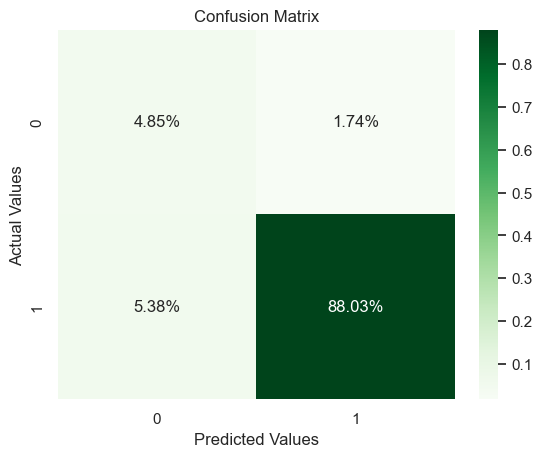

In [84]:
plotConfusionMatrix(y_test, y_pred_XGB)

### Model Inference

In [85]:
# Create a metric matrix that compares different models
metrics = {
        'Metric': ['Accuracy','Precision','Recall', 'F1Score'], 
        'Logistic Regression': metrics_LR,
        'Naive Bayes': metrics_mNB,
        'Random Forest': metrics_RF,
        'XGBoost': metrics_XGB
        }

df_metrics = pd.DataFrame(metrics ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Random Forest', 'XGBoost'] )
df_metrics

,Metric,Logistic Regression,Naive Bayes,Random Forest,XG Boost
0,Accuracy,0.912213,0.895644,0.919695,0.928781
1,Precision,0.918324,0.904162,0.930339,0.942354
2,Recall,0.986781,0.982743,0.982774,0.980649
3,F1Score,0.951323,0.941816,0.955838,0.961120


We can clearly see from the metrics that XGBoost is the best algorithm out of the 4 algorithms. Let us use the XGBoost to create a recommendation system.

Let us save our model 

In [87]:
# XGBoost Model
pickle.dump(XGB_best, open("SentimentClassificationXGBoostModel.pkl", 'wb'))

In [88]:
# tfidf Vectorizer
pickle.dump(tfidf, open("tfidfVectorizer.pkl", 'wb'))

In [89]:
# Cleaned data
pickle.dump(df_cleaned, open("CleanedData.pkl", 'wb'))

## Building a recommendation system

In [91]:
df_cleaned.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,reviews_fullreview,reviews_cleanedtext,reviews_Lemmatext
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,joshua,1,Just Awesome i love this album. it's very good...,just awesome i love this album it s very good...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,dorothy w,1,Good Good flavor. This review was collected as...,good good flavor this review was collected as...,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,dorothy w,1,Good Good flavor.,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,rebecca,0,Disappointed I read through the reviews on her...,disappointed i read through the reviews on her...,disappointed read review look buy one couple l...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,walker557,0,Irritation My husband bought this gel for us. ...,irritation my husband bought this gel for us ...,irritation husband buy gel us gel cause irrita...


In [93]:
(df_cleaned.isnull().sum()/len(df))*100

id                      0.000000
brand                   0.000000
categories              0.000000
manufacturer            0.470000
name                    0.000000
reviews_date            0.133333
reviews_didPurchase    46.683333
reviews_doRecommend     8.470000
reviews_rating          0.000000
reviews_username        0.000000
user_sentiment          0.000000
reviews_fullreview      0.000000
reviews_cleanedtext     0.000000
reviews_Lemmatext       0.000000
dtype: float64

In [94]:
df_recommend = df_cleaned[["id", "name", "reviews_rating", "reviews_username"]]

In [97]:
df_recommend.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [95]:
(df_recommend.isnull().sum()/len(df))*100

id                  0.0
name                0.0
reviews_rating      0.0
reviews_username    0.0
dtype: float64

### Train Test Split

In [96]:
train, test = train_test_split(df_recommend, test_size=0.20, random_state=31)

In [108]:
user_column = "reviews_username"
product_column = "id"
value_column = "reviews_rating"

### User Based Recommendation System

In [106]:
# Pivot the train ratings' dataset into matrix format where columns are product ids and the rows are usernames.
df_pivot = pd.pivot_table(train, index='reviews_username', columns='id', values='reviews_rating').fillna(0)
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Creating Dummy train and test

In [107]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [109]:
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [110]:
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### User Similarity Matrix

In [111]:
df_pivot.index.nunique()

20511

##### Using cosine_similarity function

In [115]:
userCorrelation = cosine_similarity(df_pivot)
userCorrelation[np.isnan(userCorrelation)] = 0
print("User Correlation: \n")
print(userCorrelation)
print("\n Shape of User Correlation: ", userCorrelation.shape)

User Correlation: 

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]

 Shape of User Correlation:  (20511, 20511)


#### Prediction User-User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [116]:
userCorrelation[userCorrelation<0]=0
userCorrelation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [117]:
user_predicted_ratings = np.dot(userCorrelation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.31008684, ..., 0.        , 2.37170825,
        0.54410719],
       [0.        , 0.        , 5.1691701 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.39528471, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 0.        , 2.08333333,
        0.57353933],
       [0.        , 0.        , 0.39528471, ..., 0.        , 0.        ,
        2.88675135]])

As we are interested only in the products that are not rated by the user, hence we multiply them with dummy train to make it zero.

In [118]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.532848,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.310087,19.832141,0.0,0.0,0.0,2.210643,0.000000,0.386014,...,2.738613,0.000000,1.875495,0.0,0.0,2.950062,2.769105,0.0,2.371708,0.544107
01impala,0.0,0.0,5.169170,26.777713,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,0.000000,1.555428,1.476119,0.0,0.0,0.000000,3.684750,0.0,0.000000,0.000000
02dakota,0.0,0.0,5.169170,26.777713,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,0.000000,1.555428,1.476119,0.0,0.0,0.000000,3.684750,0.0,0.000000,0.000000
0325home,0.0,0.0,0.395285,18.638045,0.0,0.0,0.0,6.010227,6.969548,2.034471,...,0.000000,0.000000,0.000000,0.0,0.0,4.332638,0.000000,0.0,0.000000,2.886751


#### Top 20 recommendations for the user

In [132]:
user = "sandy" 
print('user: ', user)

user:  sandy


In [133]:
top20Recommendations = user_final_rating.loc[user].sort_values(ascending=False)[0:20]
top20Recommendations

id
AVpfPaoqLJeJML435Xk9    168.086745
AVpf0eb2LJeJML43EVSt     56.624308
AVpf2tw1ilAPnD_xjflC     37.151636
AVpf63aJLJeJML43F__Q     35.105431
AVpf5olc1cnluZ0-tPrO     24.023531
AVpe8gsILJeJML43y6Ed     23.203716
AVpf385g1cnluZ0-s0_t     18.267119
AVpfR5m0LJeJML436K3W     17.979188
AVpfBrUZilAPnD_xTUly     16.905933
AVpf0thK1cnluZ0-r8vR     14.216073
AVpe31o71cnluZ0-YrSD     11.247900
AVpfOIrkilAPnD_xXgDG     10.647044
AV1l8zRZvKc47QAVhnAv     10.443886
AVpfN6Z71cnluZ0-gZmO     10.056092
AVpe9W4D1cnluZ0-avf0      9.826208
AVpfPnrU1cnluZ0-g9rL      9.727595
AVpfMpZ51cnluZ0-f_L9      9.400215
AVpfov9TLJeJML43A7B0      8.748498
AVpfoSS51cnluZ0-oVH9      7.880176
AVpe6n2_LJeJML43yOgE      7.591461
Name: sandy, dtype: float64

Let us display top 20 products with id, name with it's similarity score

In [135]:
final20Recommendations = pd.DataFrame({'product_id': top20Recommendations.index, 'similarity_score' : top20Recommendations})
final20Recommendations.reset_index(drop=True)
pd.merge(final20Recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,168.086745
2666,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),56.624308
3354,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),37.151636
3899,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",35.105431
4606,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,24.023531
4756,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",23.203716
5008,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",18.267119
5161,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,17.979188
5322,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",16.905933
5441,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),14.216073


#### Evaluation User-User

In [136]:
# Find out the common users of test and train dataset.
commonUsers = test[test.reviews_username.isin(train.reviews_username)]
commonUsers.shape

(1460, 4)

In [137]:
commonUsers.head()

,id,name,reviews_rating,reviews_username
10481,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,debster
19701,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,laura30
20083,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,suzweet
19708,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,krotz03
29188,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,4,toshcal


#### User-Product Matrix

In [139]:
# convert into the user-product matrix.
common_user_matrix = pd.pivot_table(commonUsers, index=user_column, columns = product_column, values = value_column)
common_user_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,...,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Converting user correlation matrix into a pandas dataframe

In [140]:
user_correlation_df = pd.DataFrame(userCorrelation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20501,20502,20503,20504,20505,20506,20507,20508,20509,20510
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0


In [141]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20501,20502,20503,20504,20505,20506,20507,20508,20509,20510
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0


In [145]:
list_user_name = commonUsers.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_user_name)]

In [146]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_user_name)]

In [147]:
user_correlation_df_3 = user_correlation_df_2.T

In [148]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_matrix.fillna(0))
common_user_predicted_ratings

array([[3.31133089, 0.43115566, 0.        , ..., 0.        , 0.14216373,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.4472136 ,
        5.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.14002801, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.4472136 ,
        5.        ],
       [0.        , 1.23091491, 1.12390297, ..., 0.        , 0.        ,
        0.        ]])

In [150]:
dummy_test = commonUsers.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)
dummy_test.shape

(1287, 104)

In [151]:
common_user_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,...,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [153]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,...,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model Evaluation

In [166]:
from numpy import *
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [167]:
common_ = pd.pivot_table(commonUsers, index=user_column, columns = product_column, values = value_column)

In [168]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [169]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.12430836942762


RMSE for User based recommender is 2.12

### Item based recommendation System

In [170]:
df_pivot = pd.pivot_table(train, index=product_column, columns=user_column, values=value_column)
df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Building item similarity matrix

In [188]:
itemCorrelation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
itemCorrelation[np.isnan(itemCorrelation)] = 0
print(itemCorrelation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [189]:
# Item correlation
itemCorrelation[itemCorrelation<0]=0
itemCorrelation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction Item-Item

In [190]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T), itemCorrelation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03368633,
        0.        ],
       [0.        , 0.        , 0.011737  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00583537],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05614388,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0046683 ]])

In [191]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.016081,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.010653,0.0,0.0,0.0,0.0,0.021143,0.004789,0.0,0.033686,0.000000
01impala,0.0,0.0,0.011737,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.004694,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.019562,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.007823,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
0325home,0.0,0.0,0.000000,0.002420,0.0,0.0,0.0,0.00136,0.003048,0.001628,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.005835


##### Top 20 recommendations for the user

In [192]:
user = "sandy" 
print('user: ', user)

user:  sandy


In [193]:
# Recommending the Top 20 products to the user.
top20ItemRecommendations = item_final_rating.loc[user].sort_values(ascending=False)[0:20]
top20ItemRecommendations

id
AVpfr5cb1cnluZ0-pZFp    0.786199
AV1Ymf_rglJLPUi8II2v    0.719402
AVpf5olc1cnluZ0-tPrO    0.470340
AVpfE7puilAPnD_xUcCW    0.373281
AVpfnjBILJeJML43AkO3    0.304378
AVpfBU2S1cnluZ0-cJsO    0.273323
AVpe8q4T1cnluZ0-afct    0.268324
AVpfBpnEilAPnD_xTUBx    0.228082
AVpfRoqcLJeJML436FqG    0.201209
AVpfJcHuLJeJML433ZrY    0.191230
AVpfPnrU1cnluZ0-g9rL    0.168830
AV1ZT7GLglJLPUi8IQLI    0.144827
AVpfv4TlilAPnD_xhjNS    0.142476
AVpfBO2vLJeJML430mGh    0.138554
AVpfbraG1cnluZ0-kqnn    0.136049
AVpe_5U_ilAPnD_xSrxG    0.134162
AVpe4hlXLJeJML43xbrB    0.126155
AVpe7sl91cnluZ0-aI1Y    0.122093
AVpfozgyilAPnD_xfe0r    0.117705
AVpfPaoqLJeJML435Xk9    0.107295
Name: sandy, dtype: float64

In [194]:
item_final_recommendations = pd.DataFrame({'product_id': top20ItemRecommendations.index, 'similarity_score' : top20ItemRecommendations})
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfr5cb1cnluZ0-pZFp,Boraam Sonoma Kitchen Cart With Wire Brush Gra...,0.786199
22,AV1Ymf_rglJLPUi8II2v,Cars Toon: Mater's Tall Tales,0.719402
47,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,0.470340
197,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.373281
202,AVpfnjBILJeJML43AkO3,Progresso Traditional Chicken Tuscany Soup,0.304378
206,AVpfBU2S1cnluZ0-cJsO,Power Crunch Protein Energy Bar Peanut Butter ...,0.273323
232,AVpe8q4T1cnluZ0-afct,"Newman's Own Organics Licorice Twist, Black 5oz",0.268324
237,AVpfBpnEilAPnD_xTUBx,"All,bran Complete Wheat Flakes, 18 Oz.",0.228082
248,AVpfRoqcLJeJML436FqG,"Vicks Vaporub, Regular, 3.53oz",0.201209
326,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.191230


#### Evaluation Item-Item

In [195]:
common =  test[test.id.isin(train.id)]
common.shape

(5979, 4)

In [196]:
common.head()

,id,name,reviews_rating,reviews_username
26716,AVpfPPkEilAPnD_xX3cP,Aveeno Baby Continuous Protection Lotion Sunsc...,5,byluckyiyu
11689,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,sdurunna
18300,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,5,javier
25410,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,dbztimmy
10481,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,debster


In [197]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [198]:
item_correlation_df = pd.DataFrame(itemCorrelation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001727,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [200]:
list_name = common.id.tolist()

In [201]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [202]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

In [203]:
item_correlation_df_3 = item_correlation_df_2.T

In [204]:
df_subtracted

reviews_username,00dog3,00sab00,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1085,10ten,...,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftymALJeJML43CZ6y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.01564933, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00241952, 0.00311453, ..., 0.        , 0.        ,
        0.00096781],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0171317 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00437527, 0.        ,
        0.        ],
       [0.        , 0.00583537, 0.        , ..., 0.        , 0.        ,
        0.00233415]])

In [206]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)

dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [207]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

#### Model Evaluation

In [208]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)     

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [210]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

5817

In [211]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5768680385424574


RMSE for Item based recommender is 3.57

## User based recommendation vs Item based recommendation system
RMSE (User based recommender) = 2.12
RMSE (Item based recommender) = 3.57

As user based recommendation system has a lower root mean squared error, it is a better model than item based recommendation system.

In [212]:
# Let us save the user based recommendation model
pickle.dump(user_final_rating, open("UserBasedRecommendationModel.pkl", 'wb'))

## Top Product recommendations using sentiment model

In [213]:
def GetSentimentRecommendations(user):
    if (user in user_final_rating.index):
        # Get the product recommendations using the trained ML model 'user_final_rating'
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_cleaned[df_cleaned.id.isin(recommendations)]
        # transform the input data using saved tf-idf vectorizer
        X =  tfidf.transform(temp["reviews_Lemmatext"].values.astype(str))
        # Predict using the saved XGBoost model
        temp["predicted_sentiment"]= XGB_best.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} does not exist.")

In [214]:
# Get sentiment predictions for user 'sandy'
GetSentimentRecommendations("sandy")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
16,Red (special Edition) (dvdvideo),672,651,672,96.88
17,Stargate (ws) (ultimate Edition) (director's C...,186,177,186,95.16
18,The Resident Evil Collection 5 Discs (blu-Ray),845,803,845,95.03
14,Olay Regenerist Deep Hydration Regenerating Cream,634,594,634,93.69
10,Godzilla 3d Includes Digital Copy Ultraviolet ...,3325,3084,3325,92.75
0,100:Complete First Season (blu-Ray),139,128,139,92.09
13,Jason Aldean - They Don't Know,204,187,204,91.67
9,Dark Shadows (includes Digital Copy) (ultravio...,247,224,247,90.69
3,"Burt's Bees Lip Shimmer, Raisin",873,786,873,90.03
4,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",68,61,68,89.71


### Top 5 recommendations for sandy

In [215]:
# Get 5 recommendations for sandy
GetSentimentRecommendations("sandy")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
16,Red (special Edition) (dvdvideo),672,651,672,96.88
17,Stargate (ws) (ultimate Edition) (director's C...,186,177,186,95.16
18,The Resident Evil Collection 5 Discs (blu-Ray),845,803,845,95.03
14,Olay Regenerist Deep Hydration Regenerating Cream,634,594,634,93.69
10,Godzilla 3d Includes Digital Copy Ultraviolet ...,3325,3084,3325,92.75


#### Testing for non existent user

In [216]:
# Passing a non existent user
GetSentimentRecommendations("Saurabh")

User name Saurabh does not exist.
